In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy import integrate
from scipy import fftpack
from scipy import signal
from scipy import interpolate
from scipy import optimize
import pickle

from chirp_diagnostic_functions import *

from IPython.core.debugger import set_trace

Import data from binary "pickle" file:

In [2]:
path = r"../../Data/Autocorrelator/Simulation/"

In [3]:
filename =  path + "2019-03-22 13_47_42.205642_Autocorrelation_Measurement" + ".pkl"

In [4]:
with open(filename, 'rb') as file:
    data_type, laser_shape, tau_values_1, I_M_filtered_values_1, \
    tau_0_laser, omega_laser, alpha_values = pickle.load(file)

Calculate $A$-arrays so that $\int f(t) dt = 1$

In [5]:
if laser_shape == "gauss":
    A = normalize_f(f_gauss, tau_0_laser, omega_laser)
if laser_shape == "secant":
    A = normalize_f(f_secant, tau_0_laser, omega_laser)

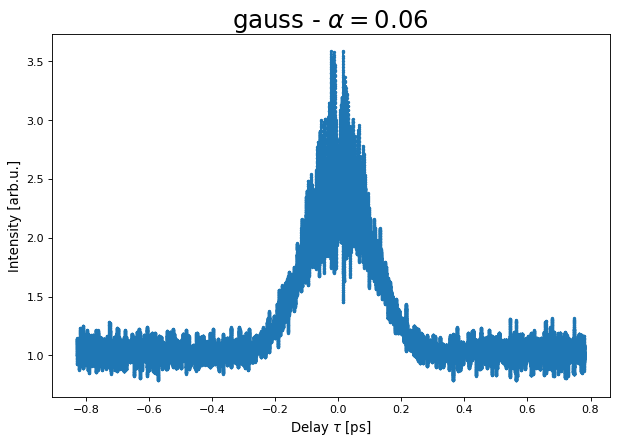

In [6]:
# Create a figure of size 8x6 inches, 80 dots per inch
plt.figure(figsize=(9, alpha_values.size * 6), dpi=80)
plt.subplots_adjust(hspace = 0.25)

for i in range(alpha_values.size):   
    
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(laser_shape + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"Intensity [arb.u.]", fontsize = 12)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", ls="-", markersize=4)   

plt.show()

## Calculate envelope

In [7]:
if data_type == "simulation":
    minima_number_samples = 3
elif data_type == "measurement":
    minima_number_samples = 1000

In [8]:
tau_envelope_values = []
I_M_envelope_values = []

for i in range(alpha_values.size):
    tau_envelope_values.append([])
    I_M_envelope_values.append([])
    # order=3 means that it checks the local minimum for three neighbors each side
    mask_local_min = signal.argrelmin(I_M_filtered_values_1[:,i], order=minima_number_samples)
    tau_envelope_values[:][i].append(tau_values_1[mask_local_min].tolist())
    I_M_envelope_values[:][i].append(I_M_filtered_values_1[:,i][mask_local_min].tolist())

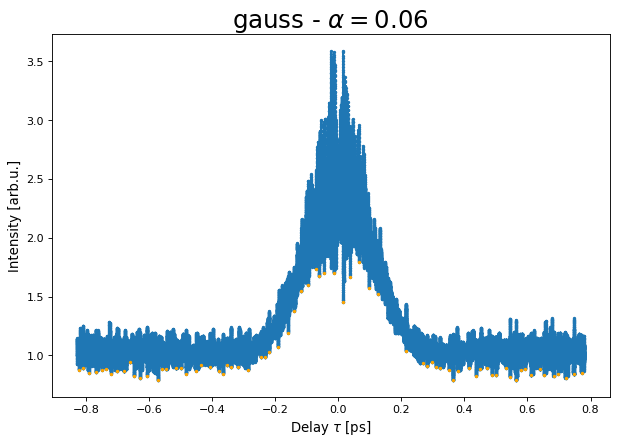

In [ ]:
plt.figure(figsize=(9, alpha_values.size * 6), dpi=80)
plt.subplots_adjust(hspace = 0.25)
for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 1, i + 1)
    plt.title(laser_shape + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"Intensity [arb.u.]", fontsize = 12)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".", ls="-", markersize=4)
    plt.plot(tau_envelope_values[:][i][0], I_M_envelope_values[:][i][0], ".", markersize=4, color="orange")

plt.show()

## Calculate envelope with known alpha_values
(see Hirayama, T., & Sheik-Bahae, M. (2002). Real-time chirp diagnostic for ultrashort laser pulses. Optics Letters, 27(10), 860. http://doi.org/10.1364/OL.27.000860)

The lower bound (minima envelope) of the MOSAIC trace is therefore given by

$$S^{min}_{MOSAIC}(\tau)= 1 + 2 \cdot g(\tau) - 2 \cdot [g_s^2(\tau)+g_c^2(\tau)]^{1/2}$$

with 

$$g(\tau)=\int f(t)f(t+\tau)dt$$
$$g_s(\tau)=\int f(t)f(t+\tau)sin(2\Delta\phi)dt$$
$$g_c(\tau)=\int f(t)f(t+\tau)cos(2\Delta\phi)dt$$

In [ ]:
def g(tau, f, A, tau_0, omega, alpha):
    func = lambda t, A, tau_0, omega, alpha : (f(t, A, tau_0, omega, alpha) 
                                               * f(t + tau, A, tau_0, omega, alpha))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
    return integrate.quad(func, - np.inf, np.inf, args=(A, tau_0, omega, alpha))[0]
    
def g_s(tau, f, delta_phi, A, tau_0, omega, alpha):
    func = lambda t, A, tau_0, omega, alpha : (f(t, A, tau_0, omega, alpha) 
                                               * f(t + tau, A, tau_0, omega, alpha) 
                                               * np.sin(2 * delta_phi(t, tau, tau_0, alpha)))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
    return integrate.quad(func, - np.inf, np.inf, args=(A, tau_0, omega, alpha))[0]

def g_c(tau, f, delta_phi, A, tau_0, omega, alpha):
    func = lambda t, A, tau_0, omega, alpha : (f(t, A, tau_0, omega, alpha) 
                                               * f(t + tau, A, tau_0, omega, alpha) 
                                               * np.cos(2 * delta_phi(t, tau, tau_0, alpha)))
    # "[0]" because quad returns array, with "[0]" as the result and "[1]" as the error
    return integrate.quad(func, - np.inf, np.inf, args=(A, tau_0, omega, alpha))[0]

In [ ]:
def S_min(tau_values, f, delta_phi, A, tau_0, omega, alpha):
    S_min_values = np.array(())
    for tau in tau_values:
        S_min_values = np.append(S_min_values, 1 + 2 * g(tau, f, A, tau_0, omega, alpha) 
                                 - 2 *(g_s(tau, f, delta_phi, A, tau_0, omega, alpha)**2 
                                     + g_c(tau, f, delta_phi, A, tau_0, omega, alpha)**2)**(1/2))
    return S_min_values

In [ ]:
def gen_S_min_values(tau_values, alpha_values,
                     f, delta_phi, A, tau_0, omega):
    S_min_values = np.empty((tau_values.size, alpha_values.size))    
    for i in range(alpha_values.size):
        S_min_values[:,i] = S_min(tau_values, f, delta_phi, A,
                                  tau_0, omega, alpha_values[i])
    return S_min_values

In [ ]:
if laser_shape == "gauss":
    S_min_values_3 = gen_S_min_values(tau_values_1, alpha_values,
                                      f_gauss, delta_phi_gauss,
                                      A, tau_0_laser, omega_laser)  
elif laser_shape == "secant":
    S_min_values_3 = gen_S_min_values(tau_values_1, alpha_values,
                                      f_secant, delta_phi_secant,
                                      A, tau_0_laser, omega_laser)  


In [ ]:
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)
plt.subplots_adjust(hspace = 0.25)
for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_shape + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"$Intensity$ [arb.u.]", fontsize = 12)
    plt.ylim(1, np.max(S_min_values_3[:,i]) * 1.05)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_1, S_min_values_3[:,i], linewidth=2, color="orange")
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_shape + r" - $\alpha = {}$".format(alpha_values[i]), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"$Intensity$ [arb.u.]", fontsize = 12)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_1, S_min_values_3[:,i], linewidth=2, color="orange")

plt.show()

## Fit envelope and find out if we get the correct alpha_value

In [ ]:
def calc_S_min_alpha_fit_values(f, delta_phi, tau_envelope_values, I_M_envelope_values, tau_0, omega, alpha_values):
    # A[0] because A is (mostly) independent of alpha
    S_min_fit = lambda tau_values, alpha : S_min(tau_values, f, delta_phi, A, tau_0, omega, alpha)
    alpha_opt = np.empty(len(tau_envelope_values))
    alpha_cov = np.empty((len(tau_envelope_values), 1))
    for i in range(len(tau_envelope_values)):
        alpha_opt[i], alpha_cov[i]  = optimize.curve_fit(S_min_fit, tau_envelope_values[:][i][0], I_M_envelope_values[:][i][0], p0=alpha_values[i], bounds=((0, np.inf)))        
        #set_trace()
    return alpha_opt, alpha_cov

In [ ]:
if laser_shape == "gauss":
    alpha_fit_opt, alpha_fit_cov  = calc_S_min_alpha_fit_values(
        f_gauss, delta_phi_gauss, tau_envelope_values,
        I_M_envelope_values, tau_0_laser, omega_laser, alpha_values)
    
    S_min_fit_values_4 = gen_S_min_values(tau_values_1,
                                                    alpha_fit_opt, f_gauss,
                                                    delta_phi_gauss, A,
                                                    tau_0_laser, omega_laser)    
elif laser_shape == "secant":
    alpha_fit_opt, alpha_fit_cov  = calc_S_min_alpha_fit_values(f_secant, delta_phi_secant, tau_envelope_values, I_M_envelope_values, tau_0_laser, omega_laser, alpha_values)
    S_min_fit_values_4 = gen_S_min_values(tau_values_1,
                                                    alpha_fit_opt, f_secant,
                                                    delta_phi_secant, A,
                                                    tau_0_laser, omega_laser)   


In [ ]:
plt.figure(figsize=(18, alpha_values.size * 6), dpi=80)
plt.subplots_adjust(hspace = 0.25)
for i in range(alpha_values.size):
    plt.subplot(alpha_values.size, 2, 2 * i + 1)
    plt.title(laser_shape + r": $\alpha = %.04f \pm %.04f$" 
              % (alpha_fit_opt[i], np.sqrt(np.diag(alpha_fit_cov[i]))), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"$Intensity$ [arb.u.]", fontsize = 12)
    plt.ylim(1, np.max(S_min_fit_values_4[:,i]) * 1.05)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_1, S_min_fit_values_4[:,i], linewidth=2, color="orange")
   
    
    plt.subplot(alpha_values.size, 2, 2 * i + 2)
    plt.title(laser_shape + r": $\alpha = %.04f \pm %.04f$" 
              % (alpha_fit_opt[i], np.sqrt(np.diag(alpha_fit_cov[i]))), fontsize=22)
    plt.xlabel(r"Delay $\tau$ [ps]", fontsize = 12)
    plt.ylabel(r"$Intensity$ [arb.u.]", fontsize = 12)
    plt.plot(tau_values_1, I_M_filtered_values_1[:,i], ".",  ls="-", markersize=4)
    plt.plot(tau_values_1, S_min_fit_values_4[:,i], linewidth=2, color="orange")

plt.show()